# Import Liberaries

In [5]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import shap

import warnings
warnings.filterwarnings("ignore")

### Read Data

In [6]:
df = pd.read_csv('./dataset/loan.csv')

In [7]:
df.shape

(887379, 74)

In [8]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Preprocessing

In [9]:
null_percentages = df.isnull().mean().sort_values(ascending=False) * 100
for column, percentage in null_percentages.items():
  if percentage:
    print({column: [round(percentage, 2), df[column].dtype]})

{'dti_joint': [99.94, dtype('float64')]}
{'annual_inc_joint': [99.94, dtype('float64')]}
{'verification_status_joint': [99.94, dtype('O')]}
{'il_util': [97.9, dtype('float64')]}
{'mths_since_rcnt_il': [97.65, dtype('float64')]}
{'open_acc_6m': [97.59, dtype('float64')]}
{'open_il_6m': [97.59, dtype('float64')]}
{'open_il_12m': [97.59, dtype('float64')]}
{'open_il_24m': [97.59, dtype('float64')]}
{'total_bal_il': [97.59, dtype('float64')]}
{'inq_last_12m': [97.59, dtype('float64')]}
{'open_rv_12m': [97.59, dtype('float64')]}
{'open_rv_24m': [97.59, dtype('float64')]}
{'max_bal_bc': [97.59, dtype('float64')]}
{'all_util': [97.59, dtype('float64')]}
{'inq_fi': [97.59, dtype('float64')]}
{'total_cu_tl': [97.59, dtype('float64')]}
{'desc': [85.8, dtype('O')]}
{'mths_since_last_record': [84.56, dtype('float64')]}
{'mths_since_last_major_derog': [75.02, dtype('float64')]}
{'mths_since_last_delinq': [51.2, dtype('float64')]}
{'next_pymnt_d': [28.51, dtype('O')]}
{'tot_coll_amt': [7.92, dtype('

Notiamo che le informazioni sui finanziamenti congiunti sono praticamnte tutte mancanti. Quindi possiamo pensare di rimuoverle

application_type
INDIVIDUAL    886868
JOINT            511
Name: count, dtype: int64


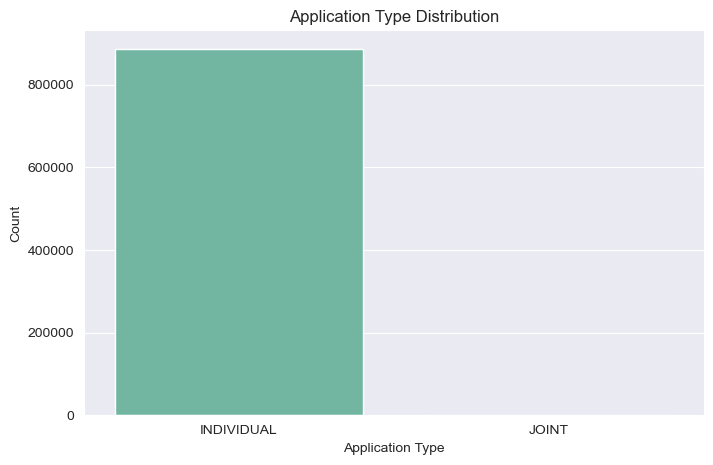

In [10]:
# Get the value counts for 'application_type'
application_type_counts = df['application_type'].value_counts()
print(application_type_counts)
# Set up the figure
plt.figure(figsize=(8, 5))

# Create the pie chart
sns.barplot(x=application_type_counts.index, y=application_type_counts.values,
            palette='bright')

# Add labels and title (optional)
plt.xlabel('Application Type')
plt.ylabel('Count')
plt.title('Application Type Distribution')

# Show the plot
plt.show()

In [11]:
df = df[df['application_type'] != 'JOINT']
columns_to_drop = [i for i in df.columns if 'joint' in i]
columns_to_drop.append('application_type') #dato che sono solo individuali possiamo togliere sta colonna

df.drop(columns=columns_to_drop, inplace=True)

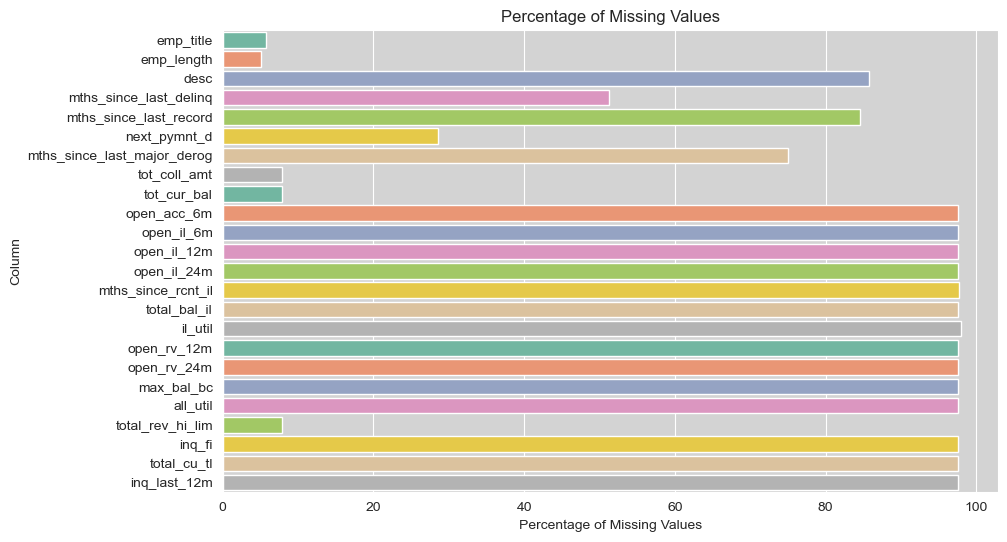

In [12]:
# Get the percentage of missing values for the 'INDIVIDUAL' application type
individual_na_percentages = df.isna().mean() * 100

# Filter columns with more than 5% missing values
individual_na_percentages = individual_na_percentages[individual_na_percentages > 5]

# Set up the figure
plt.figure(figsize=(10, 6))

# Create the bar plot using Seaborn
sns.barplot(x=individual_na_percentages.values, y=individual_na_percentages.index, palette='bright')

# Add labels and title
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Column')
plt.title('Percentage of Missing Values')

# Customize plot and background color
plt.gca().set_facecolor('lightgray')  # Background color inside the plot

# Show the plot
plt.show()

drop JOINT records to keep all values for INDIVIDUAL application_type

In [13]:
columns_to_drop = []

for i in df.columns:

  if df[i].isna().mean()*100 > 20:

    columns_to_drop.append(i)

In [14]:
df.drop(columns=columns_to_drop, inplace=True)

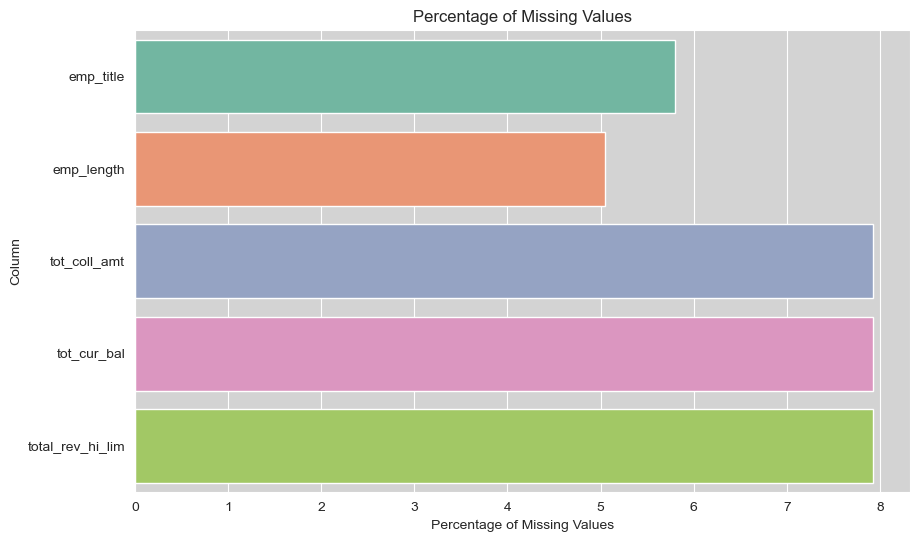

In [15]:
# Get the percentage of missing values for the 'INDIVIDUAL' application type
individual_na_percentages = df.isna().mean() * 100

# Filter columns with more than 5% missing values
individual_na_percentages = individual_na_percentages[individual_na_percentages > 5]

# Set up the figure
plt.figure(figsize=(10, 6))

# Create the bar plot using Seaborn
sns.barplot(x=individual_na_percentages.values, y=individual_na_percentages.index, palette='bright')

# Add labels and title
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Column')
plt.title('Percentage of Missing Values')

# Customize plot and background color
plt.gca().set_facecolor('lightgray')  # Background color inside the plot

# Show the plot
plt.show()

In [16]:
for i in df.columns:

  print({i: df[i].nunique()})

{'id': 886868}
{'member_id': 886868}
{'loan_amnt': 1372}
{'funded_amnt': 1372}
{'funded_amnt_inv': 9856}
{'term': 2}
{'int_rate': 542}
{'installment': 68701}
{'grade': 7}
{'sub_grade': 35}
{'emp_title': 299159}
{'emp_length': 11}
{'home_ownership': 6}
{'annual_inc': 49345}
{'verification_status': 3}
{'issue_d': 103}
{'loan_status': 10}
{'pymnt_plan': 2}
{'url': 886868}
{'purpose': 14}
{'title': 63143}
{'zip_code': 935}
{'addr_state': 51}
{'dti': 4000}
{'delinq_2yrs': 29}
{'earliest_cr_line': 696}
{'inq_last_6mths': 28}
{'open_acc': 77}
{'pub_rec': 32}
{'revol_bal': 73738}
{'revol_util': 1356}
{'total_acc': 135}
{'initial_list_status': 2}
{'out_prncp': 248246}
{'out_prncp_inv': 266137}
{'total_pymnt': 506637}
{'total_pymnt_inv': 506515}
{'total_rec_prncp': 260185}
{'total_rec_int': 324623}
{'total_rec_late_fee': 6181}
{'recoveries': 23055}
{'collection_recovery_fee': 20708}
{'last_pymnt_d': 98}
{'last_pymnt_amnt': 232437}
{'last_credit_pull_d': 103}
{'collections_12_mths_ex_med': 12}
{'

In [17]:
for i in df.columns:

    if df[i].nunique() < 10:

        print({i: df[i].value_counts()})

{'term': term
36 months    620886
60 months    265982
Name: count, dtype: int64}
{'grade': grade
B    254433
C    245717
A    148184
D    139419
E     70614
F     23022
G      5479
Name: count, dtype: int64}
{'home_ownership': home_ownership
MORTGAGE    443203
RENT        355995
OWN          87435
OTHER          182
NONE            50
ANY              3
Name: count, dtype: int64}
{'verification_status': verification_status
Source Verified    329424
Verified           290810
Not Verified       266634
Name: count, dtype: int64}
{'pymnt_plan': pymnt_plan
n    886858
y        10
Name: count, dtype: int64}
{'initial_list_status': initial_list_status
f    456703
w    430165
Name: count, dtype: int64}
{'policy_code': policy_code
1.0    886868
Name: count, dtype: int64}
{'acc_now_delinq': acc_now_delinq
0.0     882726
1.0       3865
2.0        208
3.0         28
4.0          7
5.0          3
6.0          1
14.0         1
Name: count, dtype: int64}


Le colonne categoriche che assumono principalmente un solo valore vengono rimosse in quanto non contribuiscono al potere predittivo

In [18]:
df.drop(columns=['pymnt_plan', 'policy_code', 'acc_now_delinq'], inplace=True)

In [19]:
df.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,https://www.lendingclub.com/browse/loanDetail....,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-2015,171.62,Jan-2016,0.0,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,https://www.lendingclub.com/browse/loanDetail....,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,Sep-2013,0.0,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,https://www.lendingclub.com/browse/loanDetail....,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.0,0.00,0.00,Jun-2014,649.91,Jan-2016,0.0,NaN,NaN,NaN


In [20]:
df[['grade', 'sub_grade']].head(5)

,grade,sub_grade
0,B,B2
1,C,C4
2,C,C5
3,C,C1
4,B,B5


In [21]:
df['grade'].unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

In [22]:
sub_grades = df['sub_grade'].unique().sort()

sub_grades

In [23]:
prova = df['sub_grade'].value_counts()
print(prova)

sub_grade
B3    56307
B4    55601
C1    53356
C2    52216
C3    50125
C4    48826
B5    48795
B2    48767
B1    44963
A5    44806
C5    41194
D1    36201
A4    34525
D2    29785
D3    26532
D4    25530
A3    23455
A1    22913
A2    22485
D5    21371
E1    18245
E2    16986
E3    14121
E4    11701
E5     9561
F1     7212
F2     5384
F3     4429
F4     3405
F5     2592
G1     1868
G2     1395
G3      979
G4      662
G5      575
Name: count, dtype: int64


Eliminiamo la colonna relativa alla feature grade perchè vi è già subgrades che è una versione più dettagliata
Le colonne id, member_id, url e le date relative all'issue, alla prima linea di credito aperto e l'ultima sono rimosse perchè non forniscono alcuna informazione predittiva sul rischio di credito.

In [24]:
df.drop(columns=['id', 'member_id', 'url', 'issue_d', 'earliest_cr_line', 'grade', 'last_credit_pull_d'], inplace=True)

In [25]:
df.shape

(886868, 41)

In [26]:
df.head(3)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B2,NaN,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card,Computer,860xx,AZ,27.65,0.0,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-2015,171.62,0.0,NaN,NaN,NaN
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Charged Off,car,bike,309xx,GA,1.00,0.0,5.0,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,0.0,NaN,NaN,NaN
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C5,NaN,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business,real estate business,606xx,IL,8.72,0.0,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.0,0.00,0.00,Jun-2014,649.91,0.0,NaN,NaN,NaN


Rimuoviamo title che è un duplicato di purpose e emp_title (nome dell'azienda per cui lavora il soggetto), zip_code, addr_state e last-pymnt_d perchè non forniscono alcuna informazione predittiva sul rischio di credito.

In [27]:
df.drop(columns=['emp_title', 'title', 'zip_code', 'addr_state', 'last_pymnt_d'], inplace=True)

In [28]:
df.shape

(886868, 36)

Displays the proportions of loan_status categories stacked within each employment_length category.

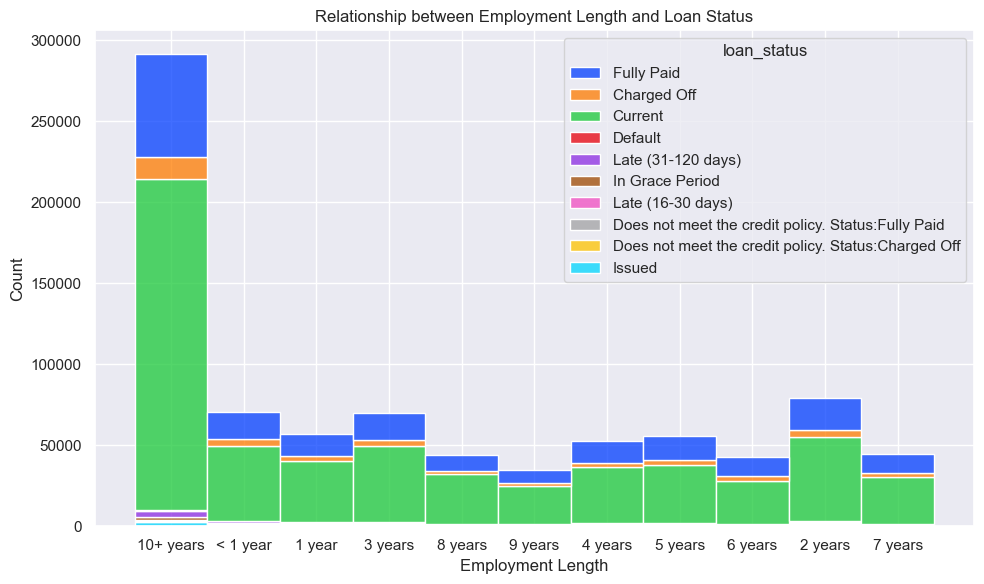

In [61]:
# Set up the figure
plt.figure(figsize=(10, 6))

sns.histplot(data=df, x="emp_length", hue="loan_status", multiple="stack", palette='bright')

# Add title and axis labels
plt.title("Relationship between Employment Length and Loan Status")
plt.xlabel("Employment Length")
plt.ylabel("Count")

# Show the plot
plt.tight_layout()
plt.show()

In [84]:
df.drop(columns=['emp_length'], inplace=True)

In [85]:
importante_features = df.columns

In [86]:
len(importante_features)

35

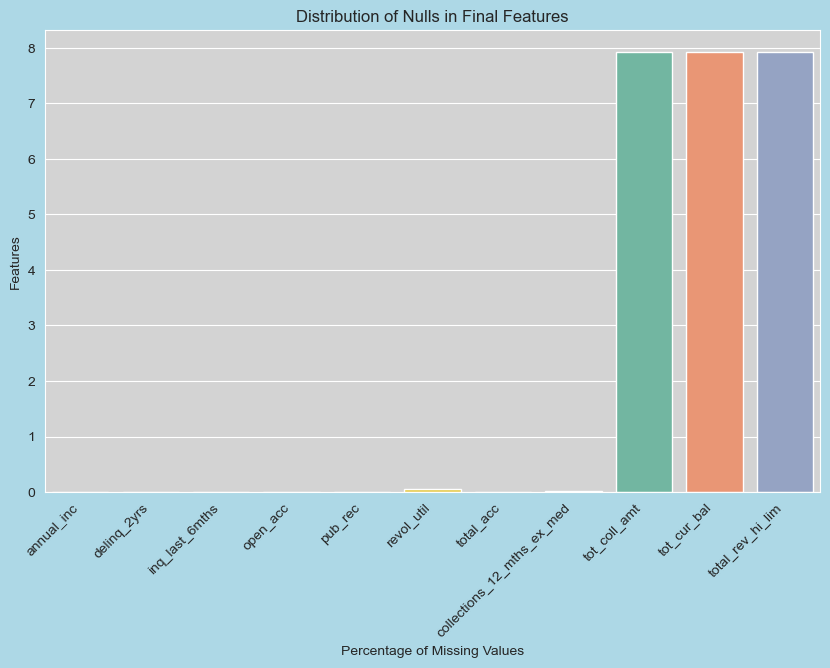

In [87]:
# Get the percentage of missing values for the entire DataFrame
na_percentages = df.isna().mean() * 100

# Filter columns with any missing values
na_percentages = na_percentages[na_percentages > 0]

# Set up the figure
plt.figure(figsize=(10, 6))

# Create the bar plot using Seaborn
sns.barplot(y=na_percentages.values, x=na_percentages.index, palette='bright')

# Add labels and title
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Features')
plt.title('Distribution of Nulls in Final Features')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')  # Rotate labels and align them to the right

# Customize background color
plt.gca().set_facecolor('lightgray')  # Background color inside the plot
plt.gcf().set_facecolor('lightblue')  # Figure background color

# Display the plot
plt.show()

In [88]:
df[na_percentages.index].info()

<class 'pandas.core.frame.DataFrame'>
Index: 886868 entries, 0 to 887378
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   annual_inc                  886864 non-null  float64
 1   delinq_2yrs                 886839 non-null  float64
 2   inq_last_6mths              886839 non-null  float64
 3   open_acc                    886839 non-null  float64
 4   pub_rec                     886839 non-null  float64
 5   revol_util                  886366 non-null  float64
 6   total_acc                   886839 non-null  float64
 7   collections_12_mths_ex_med  886723 non-null  float64
 8   tot_coll_amt                816592 non-null  float64
 9   tot_cur_bal                 816592 non-null  float64
 10  total_rev_hi_lim            816592 non-null  float64
dtypes: float64(11)
memory usage: 81.2 MB


In [89]:
na_percentages

annual_inc                    0.000451
delinq_2yrs                   0.003270
inq_last_6mths                0.003270
open_acc                      0.003270
pub_rec                       0.003270
revol_util                    0.056604
total_acc                     0.003270
collections_12_mths_ex_med    0.016350
tot_coll_amt                  7.924065
tot_cur_bal                   7.924065
total_rev_hi_lim              7.924065
dtype: float64

In [90]:
print(df.shape)

for i in na_percentages.index:

  if na_percentages[i] < 1:

    df.dropna(subset=[i], inplace=True)

print(df.shape)

(886868, 35)
(886253, 35)


## EDA and Visualizations

In [91]:
importante_features

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'sub_grade', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'purpose', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim'],
      dtype='object')

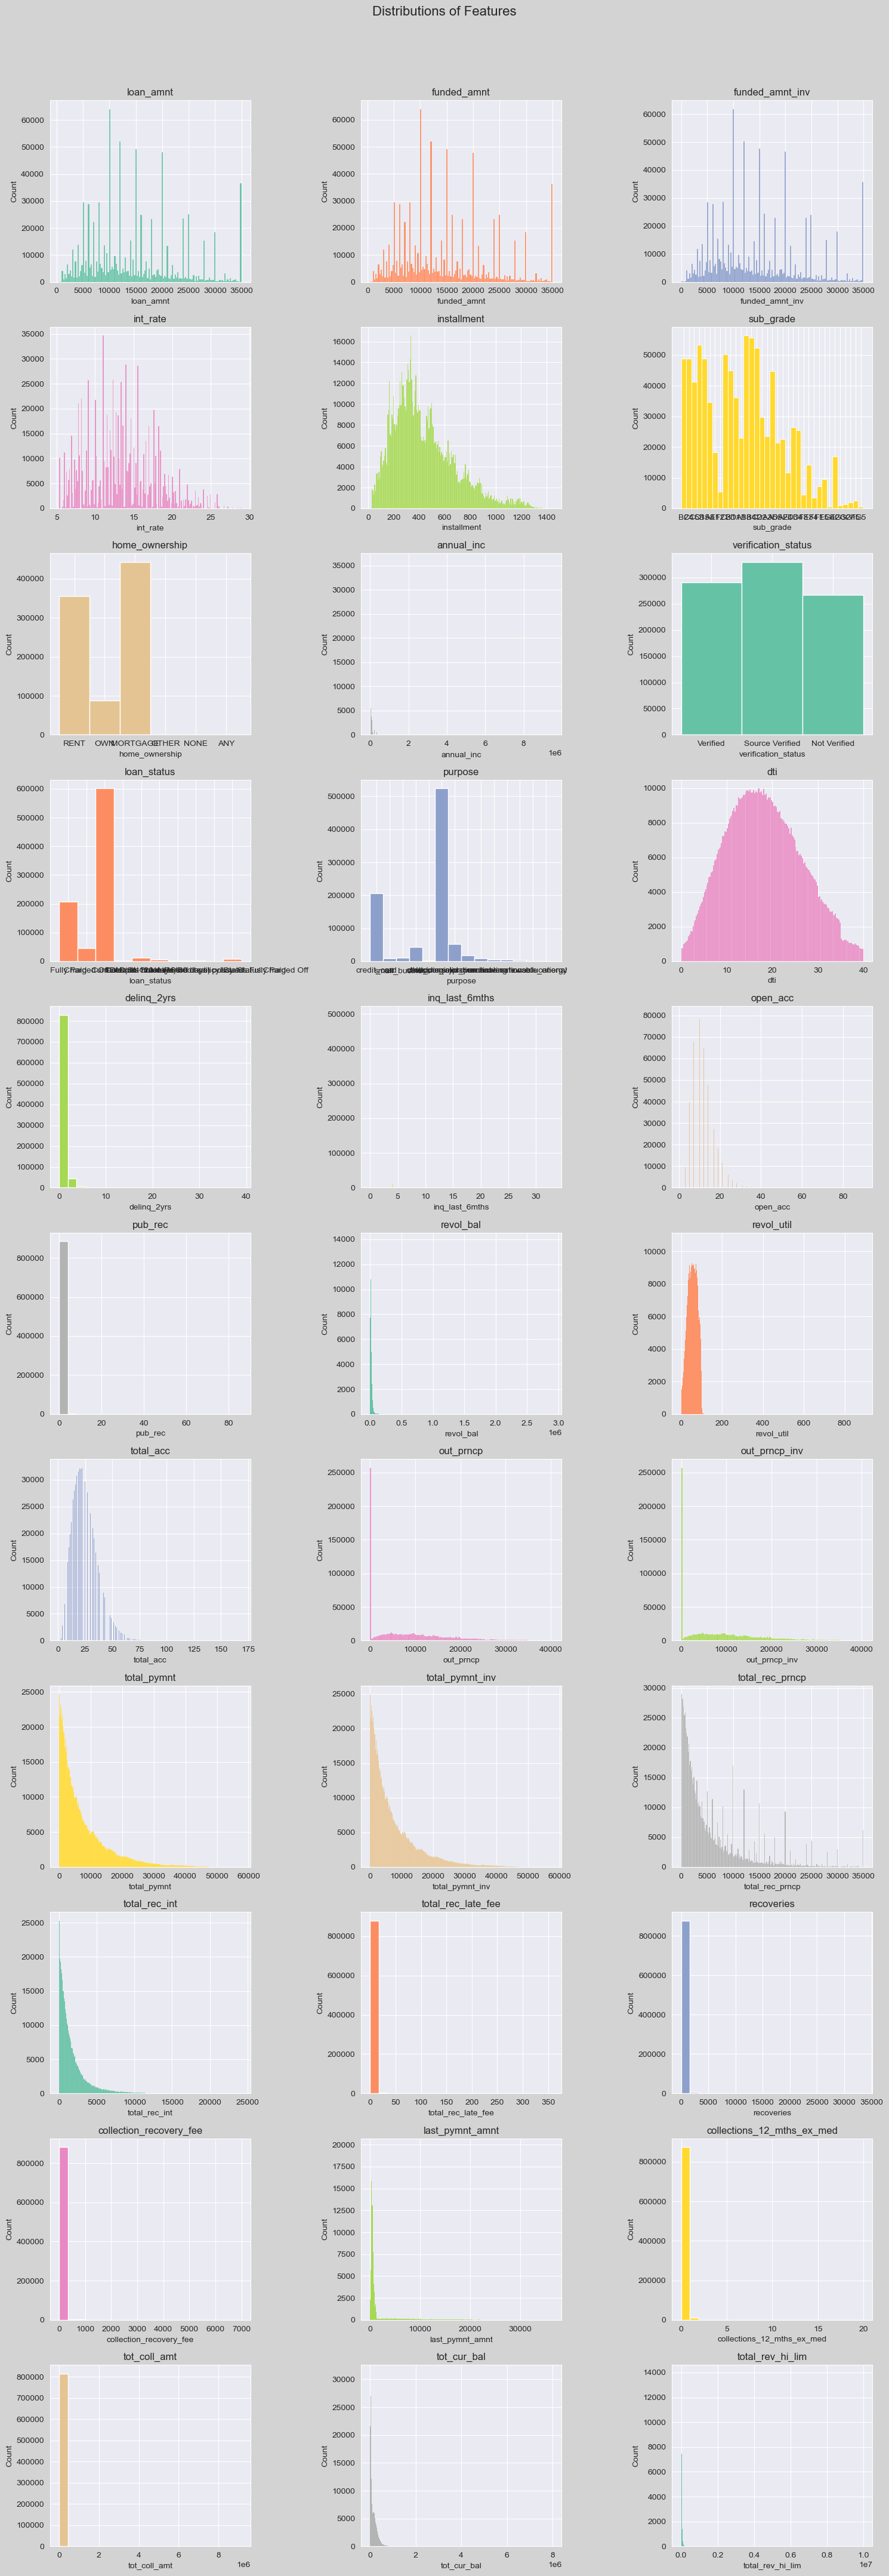

In [92]:
features = [col for col in df.columns if df[col].nunique() > 2]
rows = (len(features) + 2) // 3
cols = 3



# Set up the figure and axis for subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()  # Flatten in case of multiple rows

fig.patch.set_facecolor('lightgray')  # Set the background color of the entire figure

palette = sns.color_palette('bright', len(features))

plotted_df = df.copy()
plotted_df['diff_loan_funded'] = plotted_df['loan_amnt'] - plotted_df['funded_amnt']

for i, col in enumerate(features):
    sns.histplot(x=plotted_df[col], kde=False, ax=axes[i], color=palette[i], alpha=1)  # Set alpha slightly transparent for better visualization
    axes[i].set_title(col)



# Remove any empty subplots (in case the number of features doesn't fill the grid)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distributions of Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the main title

plt.show()

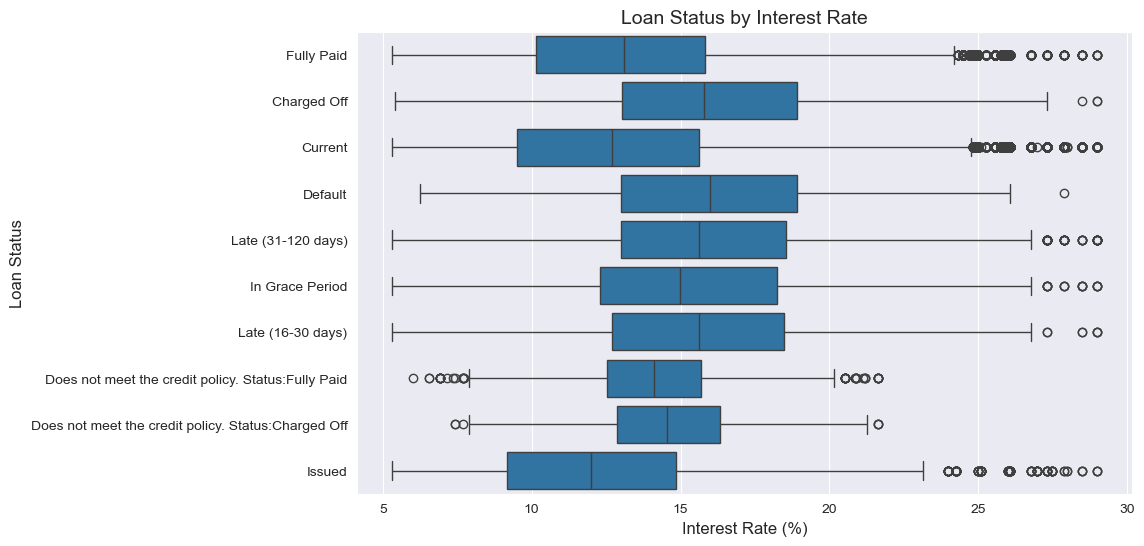

In [93]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='int_rate', y='loan_status', data=df)

plt.title('Loan Status by Interest Rate', fontsize=14)
plt.xlabel('Interest Rate (%)', fontsize=12)
plt.ylabel('Loan Status', fontsize=12)

plt.show()

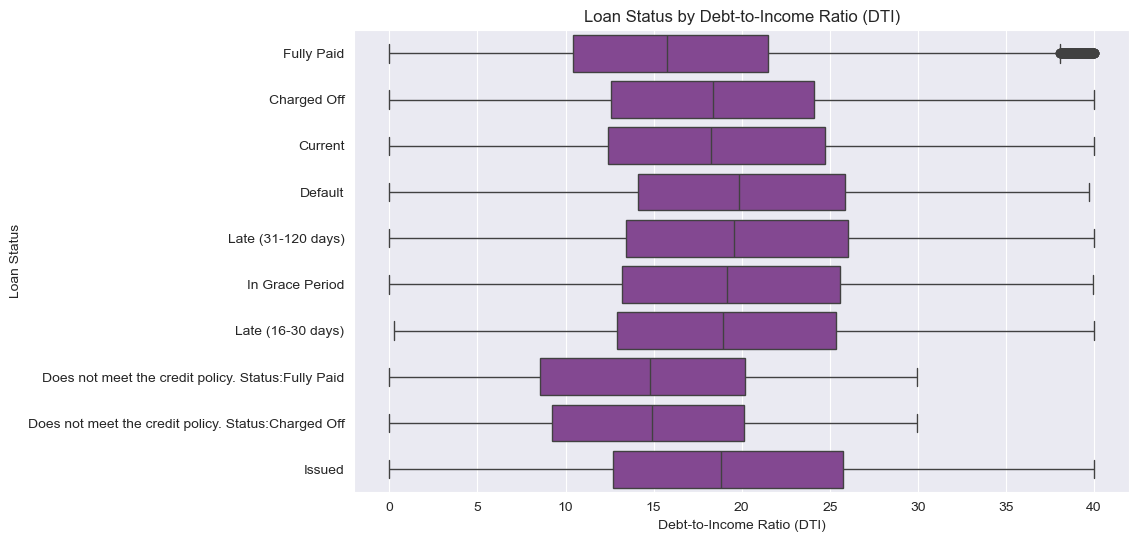

In [94]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='dti', y='loan_status', data=df, color='#8A3C9D')

plt.title('Loan Status by Debt-to-Income Ratio (DTI)')
plt.xlabel('Debt-to-Income Ratio (DTI)')
plt.ylabel('Loan Status')

plt.show()

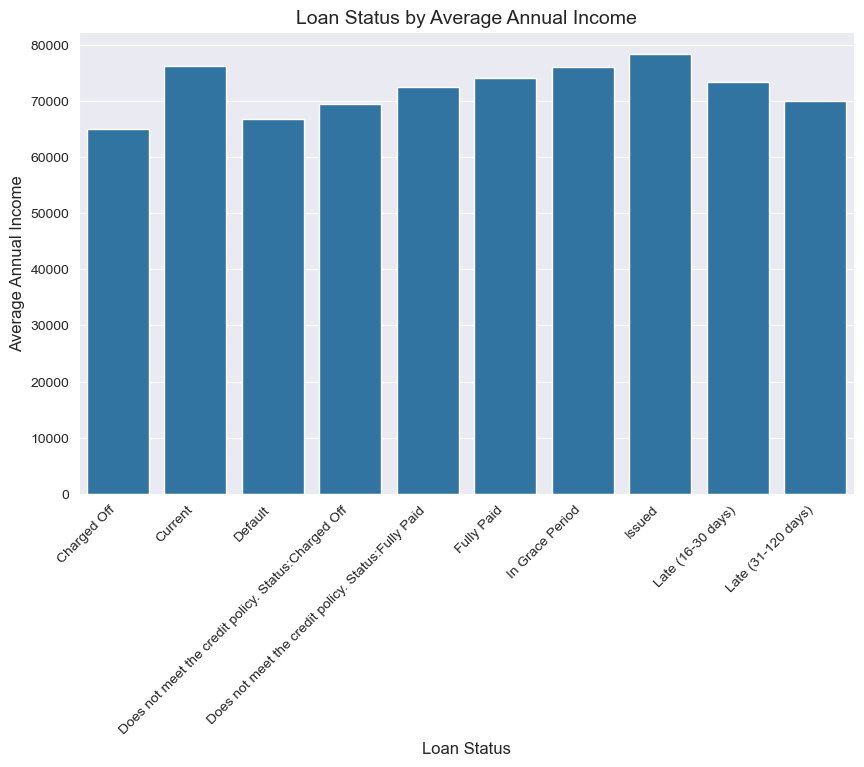

In [95]:
avg_income = df.groupby('loan_status')['annual_inc'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(y='annual_inc',x='loan_status', data=avg_income)

plt.title('Loan Status by Average Annual Income', fontsize=14)
plt.xlabel('Loan Status', fontsize=12)
plt.ylabel('Average Annual Income', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.show()

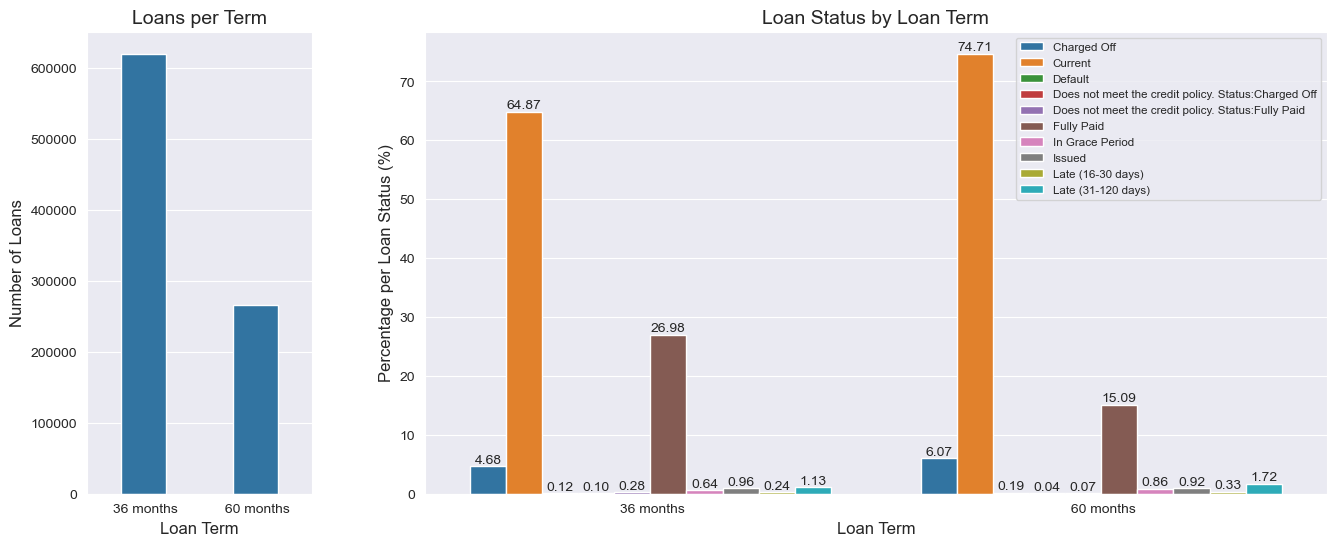

In [96]:
loans_per_term = df['term'].value_counts().reset_index()

count_data = df.groupby(['term', 'loan_status']).size().reset_index(name='count')
count_data['percentage'] = count_data['count'] / count_data.groupby('term')['count'].transform('sum') * 100

fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4])

ax1 = plt.subplot(gs[0])
sns.barplot(x='term', y='count', data=loans_per_term, ax=ax1, width=0.4)
ax1.set_title('Loans per Term', fontsize=14)
ax1.set_xlabel('Loan Term', fontsize=12)
ax1.set_ylabel('Number of Loans', fontsize=12)

ax2 = plt.subplot(gs[1])
sns.barplot(x='term', y='percentage', hue='loan_status', data=count_data, ax=ax2, width=0.8)

for p in ax2.patches:
    height = p.get_height()
    if height > 0:
        ax2.text(
            p.get_x() + p.get_width() / 2.,
            height,
            f'{height:.2f}',
            ha='center',
            va='bottom'
        )

ax2.set_title('Loan Status by Loan Term', fontsize=14)
ax2.set_xlabel('Loan Term', fontsize=12)
ax2.set_ylabel('Percentage per Loan Status (%)', fontsize=12)
ax2.legend( fontsize='small')

plt.show()

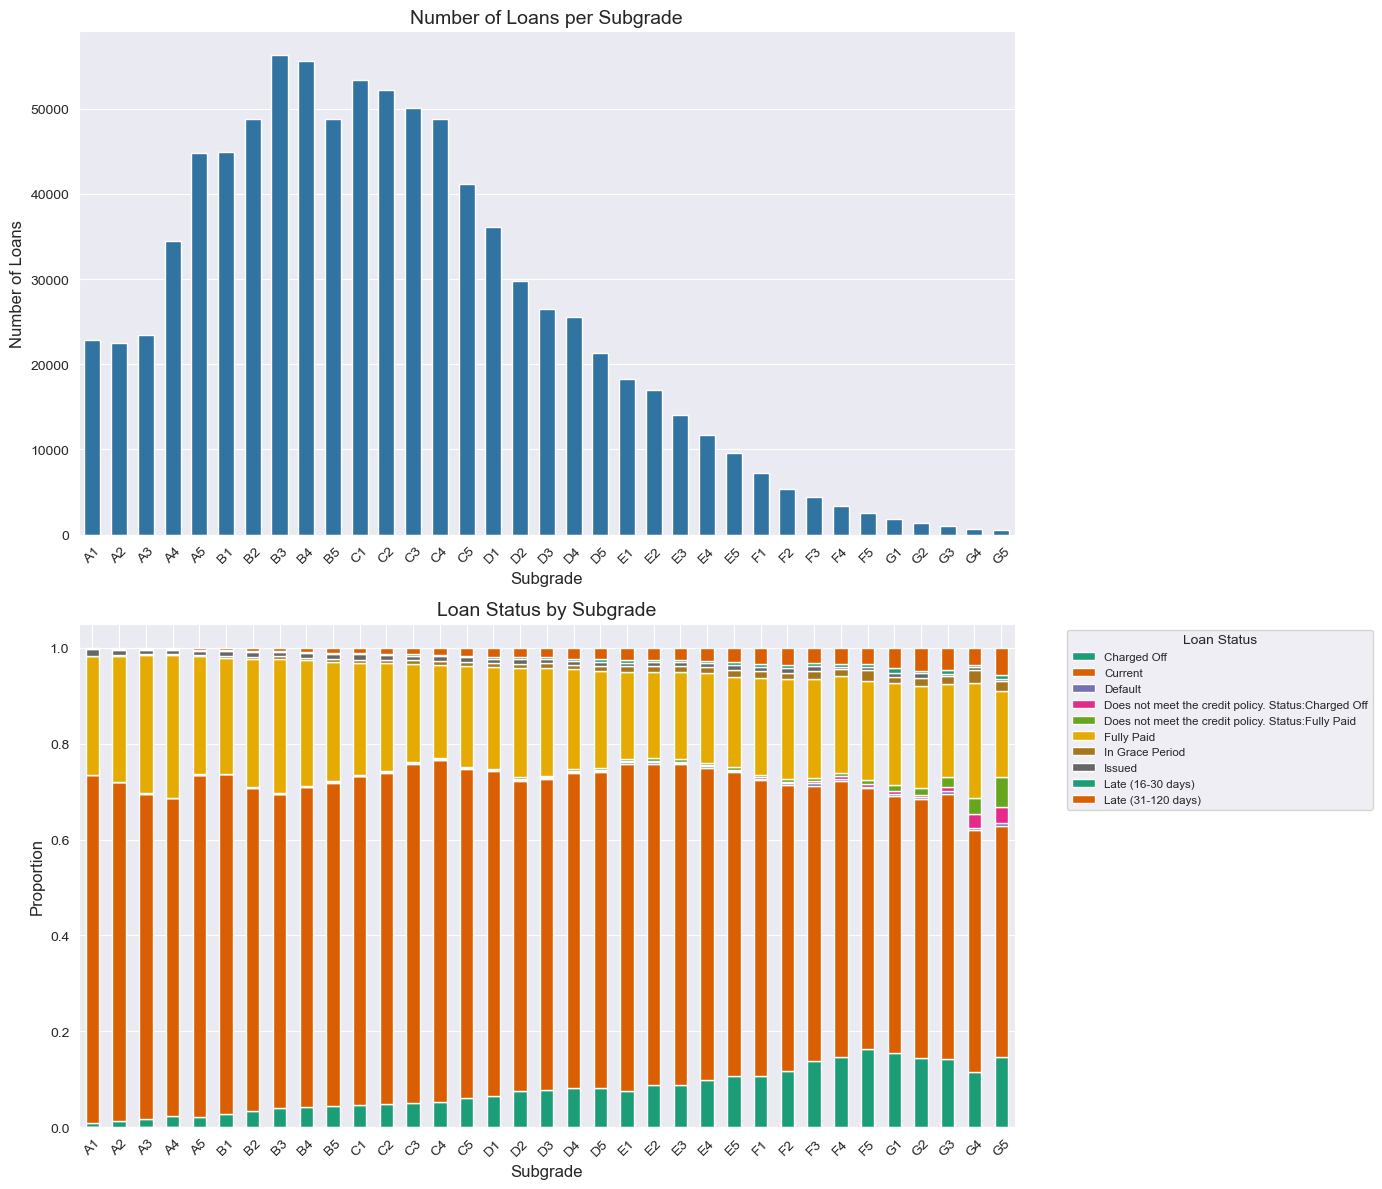

In [97]:
subgrade_counts = df['sub_grade'].value_counts().sort_index()

subgrade_proportions = df.groupby(['sub_grade', 'loan_status']).size().unstack(fill_value=0)
subgrade_proportions = subgrade_proportions.div(subgrade_proportions.sum(axis=1), axis=0)

fig, axes = plt.subplots(2, 1, figsize=(14, 12))
ax1, ax2 = axes[0], axes[1]

sns.barplot(x=subgrade_counts.index, y=subgrade_counts.values, ax=ax1, width=0.6)
ax1.set_title('Number of Loans per Subgrade', fontsize=14)
ax1.set_xlabel('Subgrade', fontsize=12)
ax1.set_ylabel('Number of Loans', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

subgrade_proportions.plot(kind='bar', stacked=True, ax=ax2, color=sns.color_palette('Dark2'))
ax2.set_title('Loan Status by Subgrade', fontsize=14)
ax2.set_xlabel('Subgrade', fontsize=12)
ax2.set_ylabel('Proportion', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()

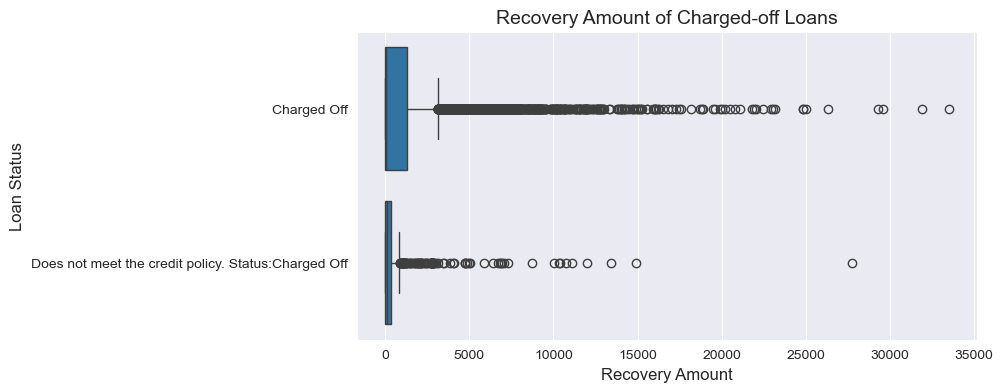

In [98]:
charges_off_df = df[df['loan_status'].str.contains('Charged Off')]

plt.figure(figsize=(8, 4))
sns.boxplot(x='recoveries', y='loan_status', data=charges_off_df)

plt.title('Recovery Amount of Charged-off Loans', fontsize=14)
plt.ylabel('Loan Status', fontsize=12)
plt.xlabel('Recovery Amount', fontsize=12)

plt.show()

<Figure size 800x1000 with 0 Axes>

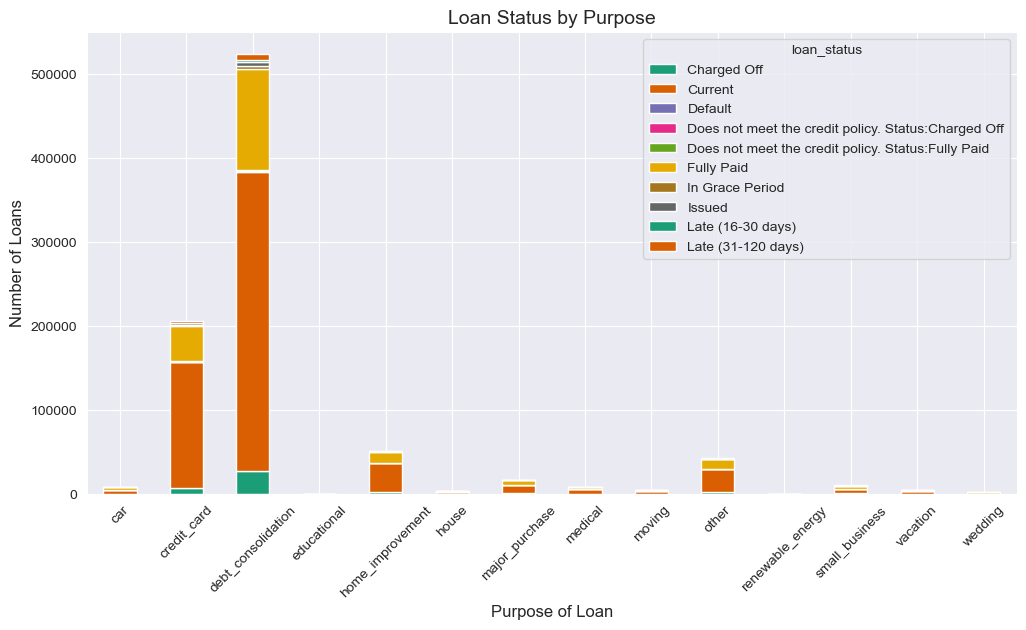

In [99]:
purpose_status_counts = df.groupby(['purpose', 'loan_status']).size().unstack(fill_value=0)

plt.figure(figsize=(8, 10))
purpose_status_counts.plot(kind='bar', stacked=True, figsize=(12, 6), color=sns.color_palette('Dark2'))

plt.title('Loan Status by Purpose', fontsize=14)
plt.xlabel('Purpose of Loan', fontsize=12)
plt.ylabel('Number of Loans', fontsize=12)
plt.xticks(rotation=45)

plt.show()

## Encoding

In [100]:
categorical_features = df.select_dtypes(include='object').drop(columns=['loan_status'])

In [101]:
categorical_features.head()

,term,sub_grade,home_ownership,verification_status,purpose,initial_list_status
0,36 months,B2,RENT,Verified,credit_card,f
1,60 months,C4,RENT,Source Verified,car,f
2,36 months,C5,RENT,Not Verified,small_business,f
3,36 months,C1,RENT,Source Verified,other,f
4,60 months,B5,RENT,Source Verified,other,f


In [102]:
for i in categorical_features.columns:

  print({i: categorical_features[i].value_counts()})

{'term': term
36 months    620387
60 months    265866
Name: count, dtype: int64}
{'sub_grade': sub_grade
B3    56283
B4    55568
C1    53329
C2    52179
C3    50097
C4    48785
B5    48774
B2    48748
B1    44951
A5    44791
C5    41168
D1    36164
A4    34511
D2    29754
D3    26507
D4    25506
A3    23444
A1    22907
A2    22467
D5    21345
E1    18234
E2    16960
E3    14105
E4    11687
E5     9542
F1     7203
F2     5374
F3     4422
F4     3399
F5     2589
G1     1864
G2     1388
G3      978
G4      659
G5      571
Name: count, dtype: int64}
{'home_ownership': home_ownership
MORTGAGE    442916
RENT        355748
OWN          87362
OTHER          180
NONE            44
ANY              3
Name: count, dtype: int64}
{'verification_status': verification_status
Source Verified    329259
Verified           290635
Not Verified       266359
Name: count, dtype: int64}
{'purpose': purpose
debt_consolidation    523642
credit_card           205989
home_improvement       51724
other            

In [103]:
def sub_grades_encoding_vectorized(df):
    # Define a dictionary mapping letter grades to numeric values
    grade_map = {
        'A': 7,
        'B': 6,
        'C': 5,
        'D': 4,
        'E': 3,
        'F': 2,
        'G': 1
    }

    # Vectorized operation for letter grade encoding
    grade_vals = df['sub_grade'].str.extract('([A-G])')[0].map(grade_map)

    # Vectorized operation for numeric adjustment based on 1-5
    numeric_adjustments = {
        '1': 0.8,
        '2': 0.6,
        '3': 0.4,
        '4': 0.2,
        '5': 0.0
    }

    # Extract the numeric suffix (1, 2, 3, etc.) and apply the corresponding adjustment
    numeric_vals = df['sub_grade'].str.extract('([1-5])')[0].map(numeric_adjustments).fillna(0)

    # Combine the grade and numeric adjustments
    df['sub_grade'] = grade_vals + numeric_vals

    return df

# verification status encoding
def verification_status(x):
    # Return 0 for 'Not Verified' and 1 for any other status
    return 0 if x == 'Not Verified' else 1

In [104]:
# Applying the vectorized function
df = sub_grades_encoding_vectorized(df)

In [105]:
df['sub_grade'].unique()

array([6.6, 5.2, 5. , 5.8, 6. , 7.2, 3.8, 2.6, 5.4, 6.8, 4.8, 7.8, 6.4,
       6.2, 5.6, 4.6, 7.4, 7. , 4. , 7.6, 3.2, 4.4, 4.2, 2.4, 3.4, 2.2,
       2.8, 3. , 1.2, 3.6, 1.4, 1.6, 1.8, 2. , 1. ])

In [106]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['term'] = label_encoder.fit_transform(df['term'])
df['initial_list_status'] = label_encoder.fit_transform(df['initial_list_status'])

In [107]:
df['verification_status'] = df['verification_status'].apply(verification_status)

In [108]:
categorical_features = df.select_dtypes(include='object').drop(columns=['loan_status'])

In [109]:
categorical_features.isna().sum()

home_ownership    0
purpose           0
dtype: int64

In [110]:
encoded_features = pd.get_dummies(categorical_features, dtype=int)

encoded_features.head(3)

,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [111]:
df = pd.concat([df, encoded_features], axis=1)

In [112]:
df.drop(columns=categorical_features.columns, inplace=True)

In [113]:
df.head(3)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,annual_inc,verification_status,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,5000.0,5000.0,4975.0,0,10.65,162.87,6.6,24000.0,1,Fully Paid,27.65,0.0,1.0,3.0,0.0,13648.0,83.7,9.0,0,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,171.62,0.0,NaN,NaN,NaN,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2500.0,2500.0,2500.0,1,15.27,59.83,5.2,30000.0,1,Charged Off,1.00,0.0,5.0,3.0,0.0,1687.0,9.4,4.0,0,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,119.66,0.0,NaN,NaN,NaN,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2400.0,2400.0,2400.0,0,15.96,84.33,5.0,12252.0,0,Fully Paid,8.72,0.0,2.0,2.0,0.0,2956.0,98.5,10.0,0,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.0,0.00,0.00,649.91,0.0,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [114]:
df['loan_status'] = label_encoder.fit_transform(df['loan_status'])

## Handling Missing Values

In [115]:
df.isna().sum()

loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                          0
installment                       0
sub_grade                         0
annual_inc                        0
verification_status               0
loan_status                       0
dti                               0
delinq_2yrs                       0
inq_last_6mths                    0
open_acc                          0
pub_rec                           0
revol_bal                         0
revol_util                        0
total_acc                         0
initial_list_status               0
out_prncp                         0
out_prncp_inv                     0
total_pymnt                       0
total_pymnt_inv                   0
total_rec_prncp                   0
total_rec_int                     0
total_rec_late_fee                0
recoveries                        0
collection_recovery_fee     

In [117]:
# # Importing necessary libraries
from sklearn.experimental import enable_iterative_imputer #to enable iterativeImputer
from sklearn.impute import IterativeImputer

# # Initialize the IterativeImputer with optimized settings
imputer = IterativeImputer(max_iter=5, random_state=0)

# # Fit and transform the data
imputed_data = imputer.fit_transform(df)

# # Convert back to a DataFrame if needed
imputed_df = pd.DataFrame(imputed_data, columns=df.columns)

# Split Data & Scaling

In [118]:
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV

x = imputed_df.drop(columns=['loan_status'])
y = imputed_df['loan_status']

In [119]:
x_rest, X, y_rest, Y = train_test_split(x, y, test_size=0.1, random_state=42, stratify=y, shuffle=True)

In [120]:
X.shape, Y.shape

((88626, 52), (88626,))

In [121]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y, shuffle=True)

Then, one scales the features such that they are normalized with zero mean. This step is recommended for SVM since it makes fitting easier.

In [122]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [123]:
x_train = pd.DataFrame(x_train, columns=x.columns)
x_test = pd.DataFrame(x_test, columns=x.columns)

## Correlation

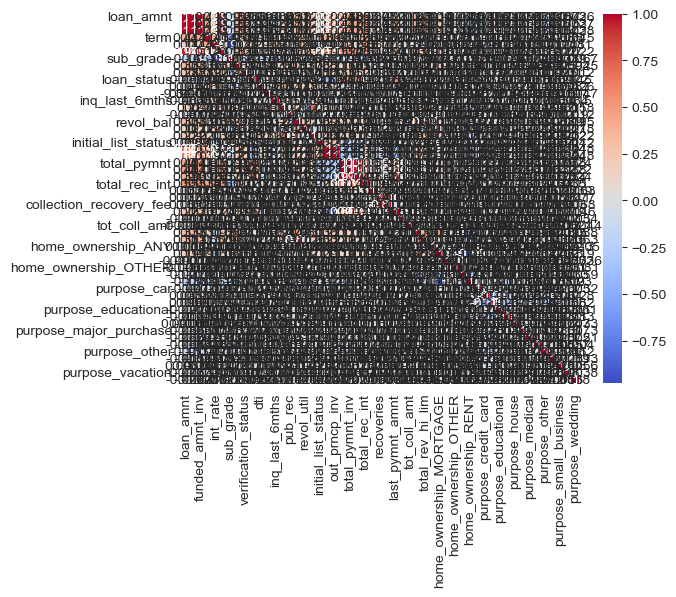

In [124]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Alta correlazione tra molte delle caratteristiche è un'indicazione che l'uso di PCA (Analisi delle Componenti Principali) potrebbe essere vantaggioso.

# Feature Reduction

In [143]:
from sklearn.decomposition import PCA

pca = PCA(n_components=len(x_train.columns))
pca.fit(x_train)

PCA(n_components=52)

In [144]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

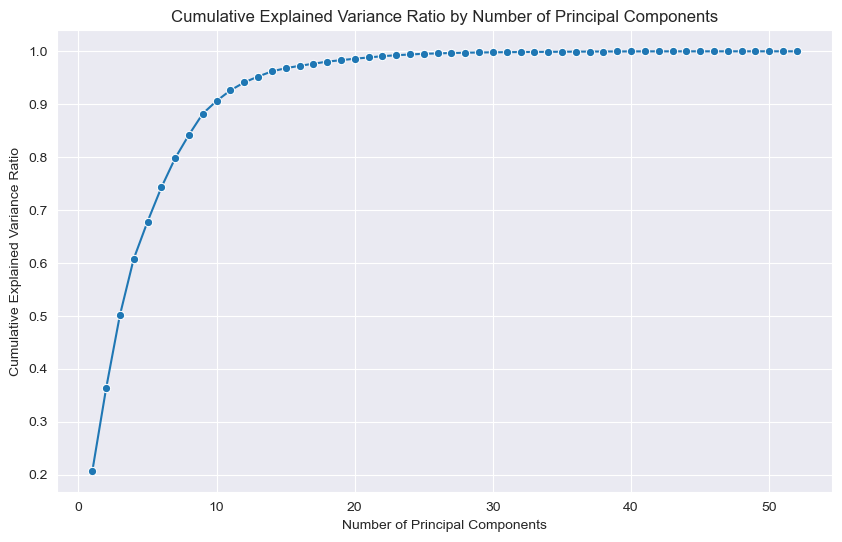

In [145]:
# Create a DataFrame for cumulative explained variance ratio
cvr = pd.DataFrame({
    'Number of Principal Components': range(1, len(cumulative_variance) + 1),
    'Cumulative Explained Variance Ratio': cumulative_variance
})

# Set up the figure
plt.figure(figsize=(10, 6))

# Create the line plot using Seaborn
sns.lineplot(data=cvr, 
             x='Number of Principal Components', 
             y='Cumulative Explained Variance Ratio', 
             marker='o')  # Adding markers for clarity

# Add title and labels
plt.title('Cumulative Explained Variance Ratio by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')

# Add grid lines for better readability
plt.grid(True)

# Show the figure
plt.show()

In [146]:
components_to_retain = np.argmax(cumulative_variance >= 0.90) + 1
pca = PCA(n_components=components_to_retain)

x_train_pca = pca.fit_transform(x_train)

x_test_pca = pca.transform(x_test)

# Modeling

## RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

rf_classifier = RandomForestClassifier(n_estimators=500,  max_depth=7, random_state=42)
rf_classifier.fit(x_train_pca, y_train)

## feature importance

In [ ]:
importances = rf_classifier.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': df.columns, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
print(feature_imp_df)

In [ ]:
# Create a bar plot for feature importance
plt.figure(figsize=(8, 4))
plt.barh(df.columns, importances, color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

#### using shap values

In [ ]:
# SHAP Explainer
explainer = shap.Explainer(rf_classifier, x_test)
shap_values = explainer(x_test)

# Initialize the SHAP JavaScript library
shap.initjs()

In [ ]:
# Waterfall plot for the first observation
shap.waterfall_plot(shap_values[0])

In [ ]:
# If SHAP values are an Explanation object, extract the values
if isinstance(shap_values, shap.Explanation):
    shap_values = shap_values.values

# Force plot for the first observation with matplotlib
# The expected_value is the model's expected output for the dataset
# The shap_values[0] represents the SHAP values for the first observation
# X_test.iloc[0, :] is the corresponding feature values for the first observation
shap.force_plot(explainer.expected_value, shap_values[0], x_test.iloc[0, :], matplotlib=True)

In [ ]:
shap.summary_plot(shap_values, x_test)

In [ ]:
shap.plots.beeswarm(shap_values)

In [148]:
y_pred_train = rf_classifier.predict(x_train_pca)

In [149]:
cm = confusion_matrix(y_train, y_pred_train)

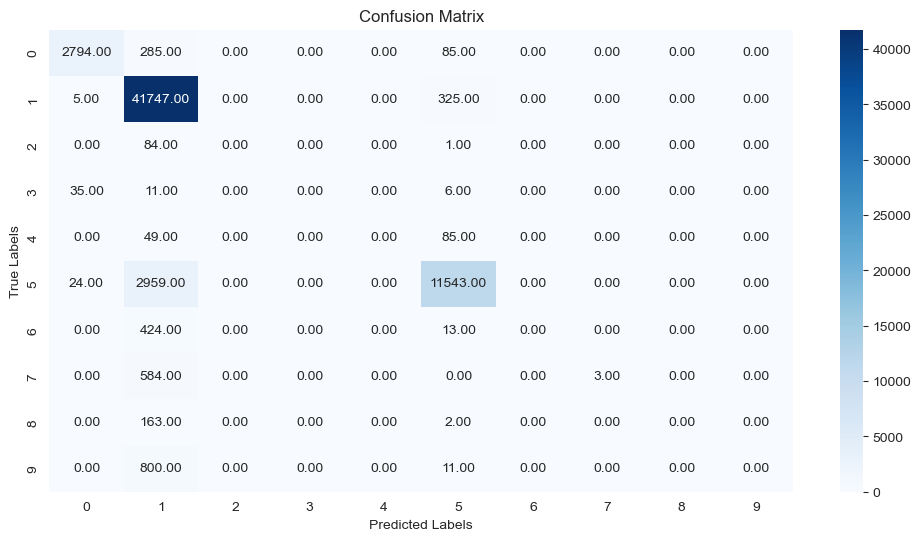

In [150]:
# Create a heatmap using Seaborn
plt.figure(figsize=(12, 6))  # Set the figure size
sns.heatmap(cm, annot=True, fmt='0.2f', cmap='Blues', cbar=True)

# Add titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

In [151]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93      3164
         1.0       0.89      0.99      0.94     42077
         2.0       0.00      0.00      0.00        85
         3.0       0.00      0.00      0.00        52
         4.0       0.00      0.00      0.00       134
         5.0       0.96      0.79      0.87     14526
         6.0       0.00      0.00      0.00       437
         7.0       1.00      0.01      0.01       587
         8.0       0.00      0.00      0.00       165
         9.0       0.00      0.00      0.00       811

    accuracy                           0.90     62038
   macro avg       0.38      0.27      0.27     62038
weighted avg       0.88      0.90      0.89     62038



In [153]:
precision_score(y_train, y_pred_train, average='weighted')

0.8843109980268706

In [154]:
recall_score(y_train, y_pred_train, average='weighted')

0.904074921822109

In [152]:
f1_score(y_train, y_pred_train, average='weighted')

0.8856395160186246

## Dopo aver trovato il best model con gridsearchCV

plot the learning curve. The learning_curve procedure takes the model, training set, train_sizes, and training/cv split as the arguments. It will return an 2D array of train_scores (accuracy for the training set) and valid_scores (accuracy for the cv set) for each training/cv split and each training size. To plot the learning curve, one can take the mean scores.

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(clf_best,x_train,y_train,train_sizes=np.linspace(0.1, 1.0, 10),cv=5)
mean_train_scores=np.mean(train_scores,axis=1)
mean_valid_scores=np.mean(valid_scores,axis=1)
std_train_scores = np.std(train_scores, axis=1)
std_valid_scores = np.std(valid_scores, axis=1)

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting the training and validation scores
ax.plot(train_sizes, mean_train_scores, 'o-', color='b', label='Training accuracy')
ax.plot(train_sizes, mean_valid_scores, 'x-', color='r', label='Validation accuracy')

# Adding shaded areas for standard deviation
ax.fill_between(train_sizes, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores,
                color='b', alpha=0.2)
ax.fill_between(train_sizes, mean_valid_scores - std_valid_scores, mean_valid_scores + std_valid_scores,
                color='r', alpha=0.2)

# Labels and title
ax.set_xlabel("Training examples")
ax.set_ylabel("Accuracy")
ax.set_title("Learning Curve")
ax.legend(loc="best")

# Show the plot
plt.grid(True)
plt.show()

The blue curve is the training score and the red is the cv score. It seems the model is neither underfitting nor overfitting. The next step is to fit the model again, and predict the results of the test set.

In [155]:
y_pred_test = rf_classifier.predict(x_test_pca)

In [156]:
cm = confusion_matrix(y_test, y_pred_test)

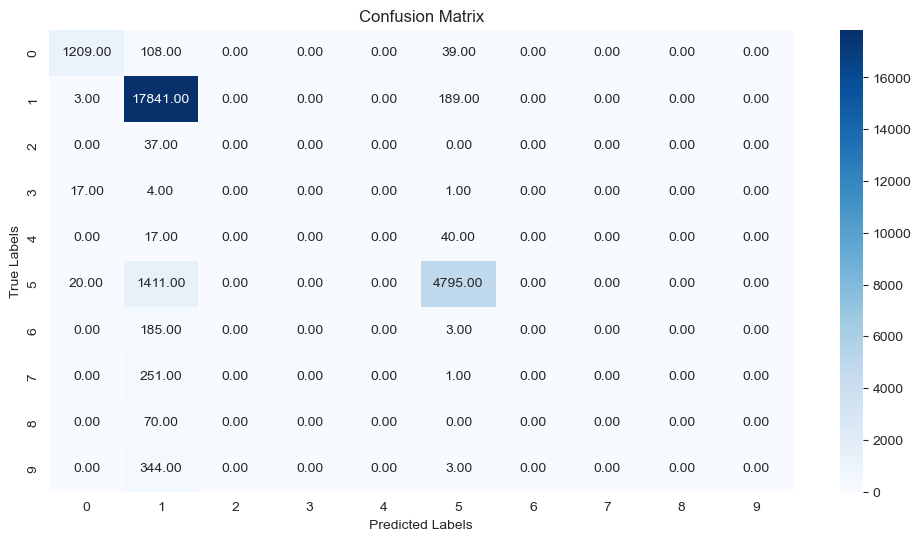

In [157]:
# Create a heatmap using Seaborn
plt.figure(figsize=(12, 6))  # Set the figure size
sns.heatmap(cm, annot=True, fmt='0.2f', cmap='Blues', cbar=True)

# Add titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

In [158]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93      1356
         1.0       0.88      0.99      0.93     18033
         2.0       0.00      0.00      0.00        37
         3.0       0.00      0.00      0.00        22
         4.0       0.00      0.00      0.00        57
         5.0       0.95      0.77      0.85      6226
         6.0       0.00      0.00      0.00       188
         7.0       0.00      0.00      0.00       252
         8.0       0.00      0.00      0.00        70
         9.0       0.00      0.00      0.00       347

    accuracy                           0.90     26588
   macro avg       0.28      0.27      0.27     26588
weighted avg       0.87      0.90      0.88     26588



In [160]:
precision_score(y_test, y_pred_test, average='weighted')

0.8678103246846056

In [161]:
recall_score(y_test, y_pred_test, average='weighted')

0.8968331578155558

In [162]:
f1_score(y_test, y_pred_test, average='weighted')

0.8779830019893452

## XGBoost

In [163]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=500,        # Number of boosting rounds
    learning_rate=0.1,       # Step size shrinkage to prevent overfitting
    max_depth=3,             # Maximum depth of a tree
    subsample=0.8,           # Subsample ratio of the training data
    colsample_bytree=0.8,    # Subsample ratio of features for each tree
    gamma=0,                 # Minimum loss reduction required to make a further partition
    reg_lambda=1,            # L2 regularization term
    objective='multi:softmax' # For multiclass classification (use 'binary:logistic' for binary)
)

In [164]:
model.fit(x_train_pca, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

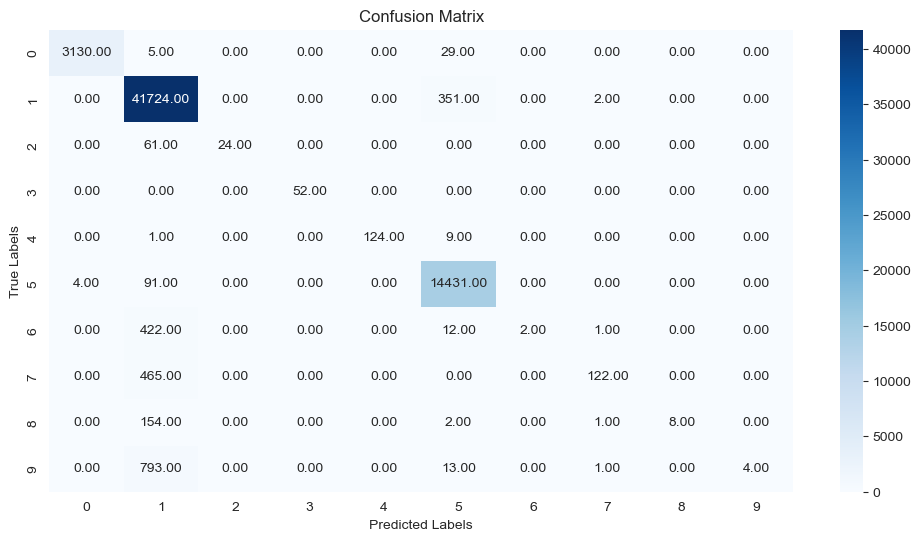

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      3164
         1.0       0.95      0.99      0.97     42077
         2.0       1.00      0.28      0.44        85
         3.0       1.00      1.00      1.00        52
         4.0       1.00      0.93      0.96       134
         5.0       0.97      0.99      0.98     14526
         6.0       1.00      0.00      0.01       437
         7.0       0.96      0.21      0.34       587
         8.0       1.00      0.05      0.09       165
         9.0       1.00      0.00      0.01       811

    accuracy                           0.96     62038
   macro avg       0.99      0.54      0.58     62038
weighted avg       0.96      0.96      0.95     62038



0.947663379680912

In [165]:
y_pred_train_xgb = model.predict(x_train_pca)

cm = confusion_matrix(y_train, y_pred_train_xgb)

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 6))  # Set the figure size
sns.heatmap(cm, annot=True, fmt='0.2f', cmap='Blues', cbar=True)

# Add titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

print(classification_report(y_train, y_pred_train_xgb))

f1_score(y_train, y_pred_train_xgb, average='weighted')

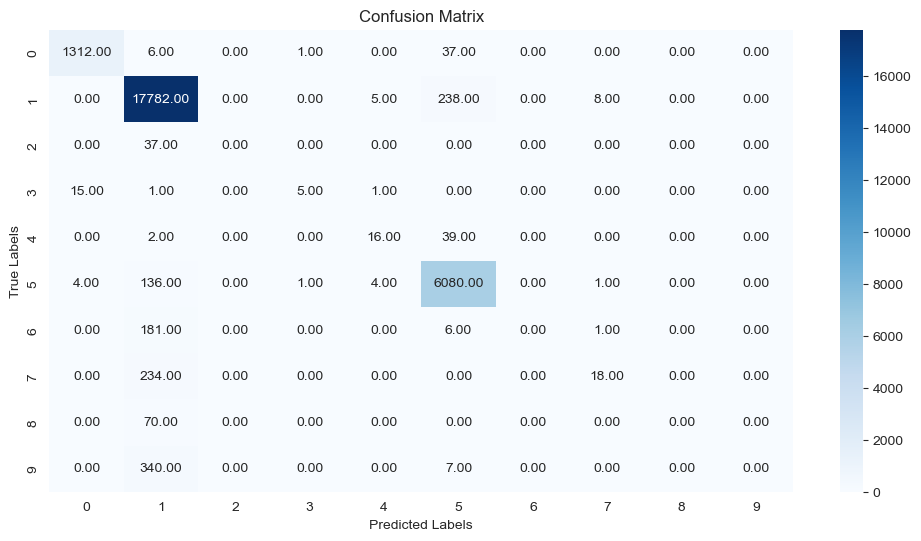

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      1356
         1.0       0.95      0.99      0.97     18033
         2.0       0.00      0.00      0.00        37
         3.0       0.71      0.23      0.34        22
         4.0       0.62      0.28      0.39        57
         5.0       0.95      0.98      0.96      6226
         6.0       0.00      0.00      0.00       188
         7.0       0.64      0.07      0.13       252
         8.0       0.00      0.00      0.00        70
         9.0       0.00      0.00      0.00       347

    accuracy                           0.95     26588
   macro avg       0.49      0.35      0.38     26588
weighted avg       0.92      0.95      0.93     26588



0.9326001063211629

In [166]:
y_pred_test_xgb = model.predict(x_test_pca)

cm = confusion_matrix(y_test, y_pred_test_xgb)

# Create a heatmap using Seaborn

plt.figure(figsize=(12, 6))  # Set the figure size
sns.heatmap(cm, annot=True, fmt='0.2f', cmap='Blues', cbar=True)

# Add titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(classification_report(y_test, y_pred_test_xgb))

f1_score(y_test, y_pred_test_xgb, average='weighted')

In [167]:
label_encoder.classes_

array(['Charged Off', 'Current', 'Default',
       'Does not meet the credit policy. Status:Charged Off',
       'Does not meet the credit policy. Status:Fully Paid', 'Fully Paid',
       'In Grace Period', 'Issued', 'Late (16-30 days)',
       'Late (31-120 days)'], dtype=object)

## XGBoost on all data

In [168]:
x = imputed_df.drop(columns=['loan_status'])

y = imputed_df['loan_status']

In [169]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y, shuffle=True)

In [170]:
x_train = scaler.fit_transform(x_train)

x_test = scaler.transform(x_test)

In [171]:
x_train = pd.DataFrame(x_train, columns=x.columns)
x_test = pd.DataFrame(x_test, columns=x.columns)

In [172]:
pca = PCA(n_components=25)

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

In [173]:
model.fit(x_train_pca, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

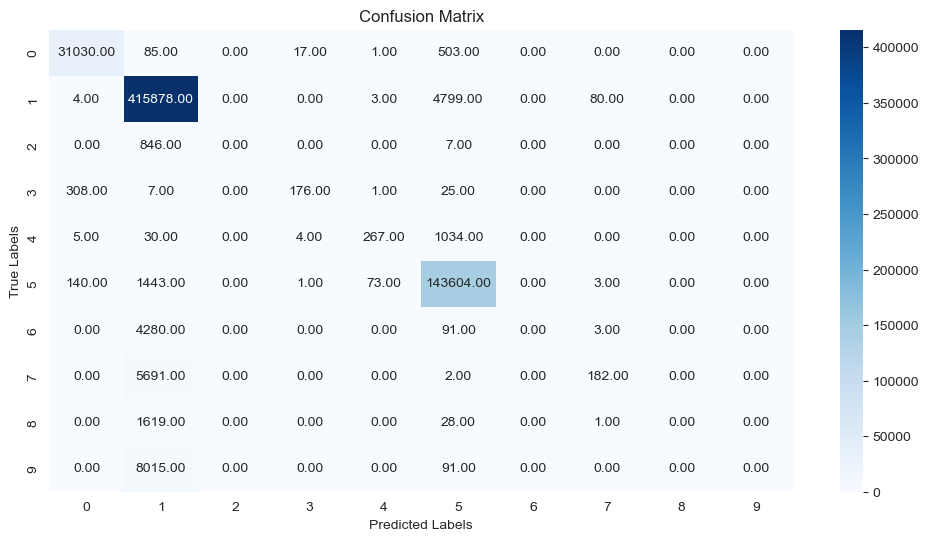

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     31636
         1.0       0.95      0.99      0.97    420764
         2.0       0.00      0.00      0.00       853
         3.0       0.89      0.34      0.49       517
         4.0       0.77      0.20      0.32      1340
         5.0       0.96      0.99      0.97    145264
         6.0       0.00      0.00      0.00      4374
         7.0       0.68      0.03      0.06      5875
         8.0       0.00      0.00      0.00      1648
         9.0       0.00      0.00      0.00      8106

    accuracy                           0.95    620377
   macro avg       0.52      0.35      0.38    620377
weighted avg       0.93      0.95      0.94    620377

Accuracy Train: 0.9528673693576648
F1 Score Trian: 0.9364055231677509


In [174]:
y_pred_train_xgb = model.predict(x_train_pca)
cm = confusion_matrix(y_train, y_pred_train_xgb)
# Create a heatmap using Seaborn
plt.figure(figsize=(12, 6))  # Set the figure size
sns.heatmap(cm, annot=True, fmt='0.2f', cmap='Blues', cbar=True)

# Add titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(classification_report(y_train, y_pred_train_xgb))

Accuracy_Train = accuracy_score(y_train, y_pred_train_xgb)
F1_Score_Train = f1_score(y_train, y_pred_train_xgb, average='weighted')

print(f"Accuracy Train: {Accuracy_Train}")
print(f"F1 Score Trian: {F1_Score_Train}")

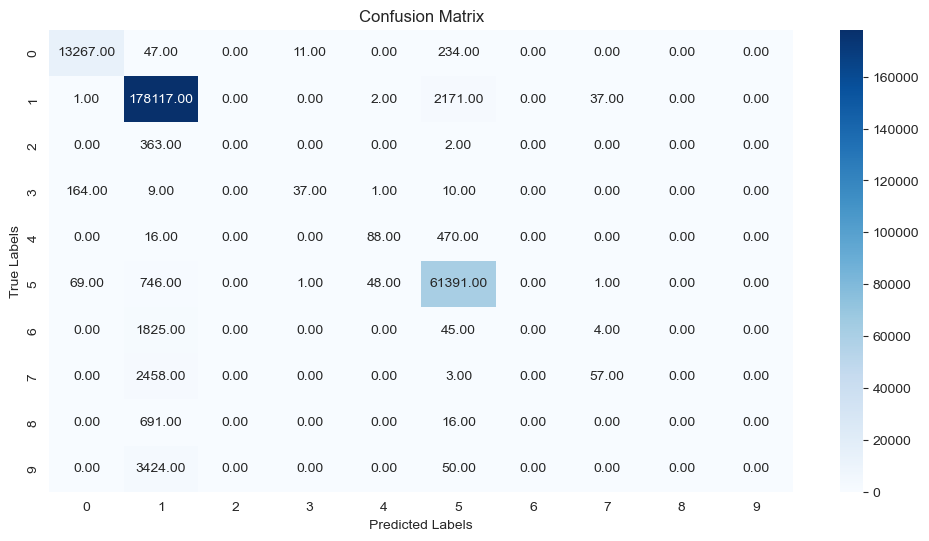

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     13559
         1.0       0.95      0.99      0.97    180328
         2.0       0.00      0.00      0.00       365
         3.0       0.76      0.17      0.27       221
         4.0       0.63      0.15      0.25       574
         5.0       0.95      0.99      0.97     62256
         6.0       0.00      0.00      0.00      1874
         7.0       0.58      0.02      0.04      2518
         8.0       0.00      0.00      0.00       707
         9.0       0.00      0.00      0.00      3474

    accuracy                           0.95    265876
   macro avg       0.48      0.33      0.35    265876
weighted avg       0.92      0.95      0.93    265876

Accuracy Test: 0.9514096797003114
F1 Score Test: 0.9346988990047985


In [175]:
y_pred_test_xgb = model.predict(x_test_pca)
cm = confusion_matrix(y_test, y_pred_test_xgb)
# Create a heatmap using Seaborn
plt.figure(figsize=(12, 6))  # Set the figure size
sns.heatmap(cm, annot=True, fmt='0.2f', cmap='Blues', cbar=True)

# Add titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(classification_report(y_test, y_pred_test_xgb))

Accuracy_Test = accuracy_score(y_test, y_pred_test_xgb)
F1_Score_Test = f1_score(y_test, y_pred_test_xgb, average='weighted')

print(f"Accuracy Test: {Accuracy_Test}")
print(f"F1 Score Test: {F1_Score_Test}")

# fine kaggle


In [180]:
# Import the package
import shap
shap.initjs()

In [ ]:
%time
samples = x_train

explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)

shap.summary_plot(shap_values[1], samples)

In [ ]:
def make_shap_waterfall_plot(shap_values, features, num_display=20):

    '''
    A function for building a SHAP waterfall plot.

    SHAP waterfall plot is used to visualize the most important features in a descending order.

    Parameters:
    shap_values (list): SHAP values obtained from a model
    features (pandas DataFrame): a list of features used in a model
    num_display(int): number of features to display

    Returns:
    matplotlib.pyplot plot: SHAP waterfall plot

    '''

    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]

    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4

    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)

    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))

In [ ]:
# Shapp waterfall plot
make_shap_waterfall_plot(shap_values[1], samples)

In [ ]:
# Let's have a look on the top features and their dependence plots
top_features = ['duration', 'euribor3m', 'nr.employed', 'emp.var.rate']
feature_list = ['age', 'cons.conf.idx', 'pdays']

In [ ]:
for feature in top_features:
    shap.dependence_plot(feature, shap_values[1], samples, interaction_index=None)

In [ ]:
for feature in feature_list:
    shap.dependence_plot(feature, shap_values[1], samples, interaction_index=None)

## SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [ ]:
# Create the SVM classifier
svm = SVC()

# Define hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10],                # Regularization parameter
    'kernel': ['linear', 'rbf'],      # Kernel types
    'gamma': ['scale', 'auto'],       # Kernel coefficient
    'degree': [3, 5]                  # Polynomial degree (only for 'poly' kernel)
}

# Perform grid search
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)

# Output the best parameters and model
print("Best parameters found: ", grid_search.best_params_)
best_svm_model = grid_search.best_estimator_

# Predict and evaluate the model on the test data
y_pred = best_svm_model.predict(x_test)
print("Classification report on test set:")
print(classification_report(y_test, y_pred))

#LOGISTIC REGRESSION

In [ ]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)


#ROC CURVE
y_pred_proba = logreg.predict_proba(x_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()